<a href="https://colab.research.google.com/github/VinishUchiha/Neural_Machine_Translation/blob/master/Seq2SeqTranslationWithAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional,RepeatVector,Concatenate,Activation,Dot,Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x ,axis=1,keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e/s

In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
NUM_SAMPLES = 10000
BATCH_SIZE = 128
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256

In [4]:
!wget https://www.manythings.org/anki/spa-eng.zip

--2020-05-23 15:04:22--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781548 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.56M  1.02MB/s    in 5.1s    

2020-05-23 15:04:27 (914 KB/s) - ‘spa-eng.zip’ saved [4781548/4781548]



In [5]:
!unzip spa-eng.zip

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [6]:
#STORE THE DATA
input_texts = []
target_texts = []
target_texts_inputs = []

t = 0
for line in open('/content/spa.txt'):
  t += 1
  if t > NUM_SAMPLES:
    break

  #input & target are seperated by tab
  if '\t' not in line:
    continue

  input_text, translation, _ = line.split('\t')

  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print('num samples:',len(input_texts))

num samples: 10000


In [7]:
#tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

word2idx_inputs = tokenizer_inputs.word_index
print(f'Found {len(word2idx_inputs)} unique input tokens')

max_len_input = max(len(s) for s in input_sequences)

tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS,filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

word2idx_outputs = tokenizer_outputs.word_index
print(f'Found {len(word2idx_outputs)} unique output tokens')

num_words_output = len(word2idx_outputs) + 1

max_len_target = max(len(s) for s in target_sequences)

#pad the sequences
encoder_inputs = pad_sequences(input_sequences,maxlen=max_len_input)
print('encoder data shape:',encoder_inputs.shape)
print('encoder data[0]:',encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs,maxlen=max_len_target,padding='post')
print('decoder data shape:',decoder_inputs.shape)
print('decoder data[0]:',decoder_inputs[0])

decoder_targets = pad_sequences(target_sequences,maxlen=max_len_target,padding='post')

Found 2350 unique input tokens
Found 6323 unique output tokens
encoder data shape: (10000, 5)
encoder data[0]: [ 0  0  0  0 13]
decoder data shape: (10000, 9)
decoder data[0]: [   2 1466    0    0    0    0    0    0    0]


In [8]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-23 15:04:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-23 15:04:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-23 15:04:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [9]:
!unzip glove.6B.zip 

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [10]:
#load pre-trained vectors
word2vec = {}
with open(os.path.join(f'/content/glove.6B.{EMBEDDING_DIM}d.txt')) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print('Found {} word vectors'.format(len(word2vec)))

Found 400000 word vectors


In [0]:
#prepare embedding matrix
num_words = min(MAX_NUM_WORDS,len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
#create embedding layer
embedding_layer = Embedding(num_words,EMBEDDING_DIM,
                            weights=[embedding_matrix],input_length=max_len_input)

In [0]:
decoder_targets_one_hot = np.zeros((
    len(input_texts),max_len_target,num_words_output
),dtype='float32')

#assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i,t,word] = 1

In [0]:
#build the model
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(LATENT_DIM,return_sequences=True,dropout=0.5))
encoder_outputs = encoder(x)

#setup decoder using [h,c] as initial state
decoder_inputs_placeholder = Input(shape=(max_len_target,))

decoder_embedding = Embedding(num_words_output,LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

#Attention
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10,activation='tanh')
attn_dense2 = Dense(1,activation=softmax_over_time)
attn_dot = Dot(axes=1)

def one_step_attention(h, st_1):
  st_1 = attn_repeat_layer(st_1)
  x = attn_concat_layer([h,st_1])
  x = attn_dense1(x)
  alphas = attn_dense2(x)
  context = attn_dot([alphas, h])
  return context

decoder_lstm = LSTM(LATENT_DIM_DECODER,return_state=True)
decoder_dense = Dense(num_words_output,activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,),name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,),name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

s = initial_s
c = initial_c

outputs = []
for t in range(max_len_target):
  context = one_step_attention(encoder_outputs,s)
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)

  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  o,s,c = decoder_lstm(decoder_lstm_input,initial_state=[s,c])

  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

def stack_and_transpose(x):

  x = K.stack(x)
  x = K.permute_dimensions(x,pattern=(1,0,2))
  return x

stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

model = Model(
    inputs=[
            encoder_inputs_placeholder,
            decoder_inputs_placeholder,
            initial_s,
            initial_c,
    ],outputs=outputs
)

In [0]:
#compile the model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
#training
z = np.zeros((NUM_SAMPLES,LATENT_DIM_DECODER)) #initial s,c
train = model.fit(
    [encoder_inputs,decoder_inputs,z,z],decoder_targets_one_hot,
    batch_size = BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Epoch 1/100
63/63 [==============================] - 10s 154ms/step - loss: 3.0656 - accuracy: 0.5910 - val_loss: 3.0579 - val_accuracy: 0.5485
Epoch 2/100
63/63 [==============================] - 6s 95ms/step - loss: 2.4133 - accuracy: 0.6351 - val_loss: 2.9016 - val_accuracy: 0.5916
Epoch 3/100
63/63 [==============================] - 6s 95ms/step - loss: 2.3085 - accuracy: 0.6453 - val_loss: 2.8832 - val_accuracy: 0.5976
Epoch 4/100
63/63 [==============================] - 6s 95ms/step - loss: 2.2173 - accuracy: 0.6540 - val_loss: 2.8090 - val_accuracy: 0.6045
Epoch 5/100
63/63 [==============================] - 6s 95ms/step - loss: 2.1209 - accuracy: 0.6630 - val_loss: 2.7542 - val_accuracy: 0.6068
Epoch 6/100
63/63 [==============================] - 6s 95ms/step - loss: 2.0380 - accuracy: 0.6723 - val_loss: 2.8004 - val_accuracy: 0.5959
Epoch 7/100
63/63 [==============================] - 6s 95ms/step - loss: 1.9657 - accuracy: 0.6791 - val_loss: 2.6295 - val_accuracy: 0.6253
Epoc

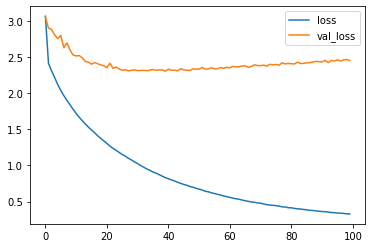

In [24]:
#ploting the loss
plt.plot(train.history['loss'],label='loss')
plt.plot(train.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

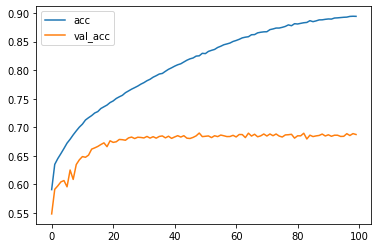

In [25]:
#ploting the acc
plt.plot(train.history['accuracy'],label='acc')
plt.plot(train.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [27]:
#make prediction
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

encoder_outputs_as_input = Input(shape=(max_len_input,LATENT_DIM*2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

context = one_step_attention(encoder_outputs_as_input,initial_s)

decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

o,s,c = decoder_lstm(decoder_lstm_input,initial_state=[initial_s,initial_c])
decoder_outputs = decoder_dense(o)

(None, 5, 512)
(None, 5, 256)


In [0]:
#create a model
decoder_model = Model(
    inputs=[
            decoder_inputs_single,
            encoder_outputs_as_input,
            initial_s,
            initial_c
    ],outputs=[decoder_outputs,s,c]
)

In [0]:
idx2word_eng = {v:k for k,v in word2idx_inputs.items()}
idx2word_trans = {v:k for k,v in word2idx_outputs.items()}

In [0]:
def decode_sequence(input_seq):
  #encode the input as state vec
  enc_out = encoder_model.predict(input_seq)

  #empty target seq of len 1
  target_seq = np.zeros((1,1))

  target_seq[0,0] = word2idx_outputs['<sos>']

  eos = word2idx_outputs['<eos>']

  s = np.zeros((1,LATENT_DIM_DECODER))
  c = np.zeros((1,LATENT_DIM_DECODER))

  #create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o ,h, c = decoder_model.predict([target_seq,enc_out,s,c])

    #GET NEXT WORD
    idx = np.argmax(o.flatten())

    if eos == idx:
      break

    word = ''
    if idx>0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    target_seq[0,0] = idx

  return " ".join(output_sentence)

In [0]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-----')
  print('Input:',input_texts[i])
  print('Translation:',translation)

  ans = input('Continue??[y/n]')
  if ans and ans[0].lower().startswith('n'):
    break